## Projekt Big Data: Analiza nastrojów przy użyciu Pyspark na przykładzie tweetach odnośnie COVID-19

**Problem**: przeanalizowanie tweetów odnośnie COVID-19 i zrozumienie, jakie nastroje towarzyszą drugiej fali pandemii

**Opis danych:** Używam pobranego zbioru danych z Twitter API, który zawiera szereg kolumn, ale do analizy będę wykorzystywać kolumny: tweet-text, id posta, sentyment obliczony przy użyciu TextBlob biblioteki (NLTK)

**Podejście:** Zastosowałam tradycyjne podejście do analizy sentymentów, a także podejście data science, które obejmuje estymatory, transformatory i zastosowanie algorytmu uczenia maszynowego do mojej analizy nastrojów, gdzie 1 oznacza dodatnie, a 0 ujemne.

Zaimportowanie  numpy, pandas and matplotlib bibliotek do czyszczenia i eksploracyjnej analizy danych

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
pd.RangeIndex(start=0, stop=100000,step=1)

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
4,application_1610791276704_0009,pyspark3,idle,Link,Link,✔


SparkSession available as 'spark'.
RangeIndex(start=0, stop=100000, step=1)

In [2]:
%%local
%matplotlib inline

Sprawdzanie zawartości bazy w Apache Hive

In [3]:
%%sql
SHOW TABLES

In [4]:
%%sql
describe tweets_pandemic

Sprawdzenie jakie mamy tendencje emocjonalne w pobranych tweetach

In [5]:
%%sql
select sentiment, count(*) as cnt from
(select case 
when polarity < 0 then 'negative'  
when polarity = 0 and subjectivity >= 0.5 then 'negative'
when polarity = 0 and subjectivity < 0.5 then 'positive'
when polarity > 0 then 'positive' 
end
as sentiment
from tweets_pandemic)
where sentiment <> 'NaN'
group by sentiment
order by sentiment

Tworzenie DataFrame na podstawie danych o tweetach w Apache Hive

In [6]:
%%time
%%sql -q -o df -n -1

select id, text as tweet, 
case 
when sentiment_string = 'negative'  then 0
when sentiment_string = 'positive'  then 1
end
as sentiment
from
(select id, text,
 case 
when polarity < 0 then 'negative'  
when polarity = 0 and subjectivity >= 0.5 then 'negative'
when polarity = 0 and subjectivity < 0.5 then 'positive'
when polarity > 0 then 'positive' 
end
as sentiment_string
from tweets_pandemic)
where sentiment_string <> 'NaN'

CPU times: user 3min 17s, sys: 23.8 s, total: 3min 41s
Wall time: 5min 30s


In [7]:
%%local
df.info()
df.index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
id           100000 non-null int64
tweet        100000 non-null object
sentiment    100000 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


RangeIndex(start=0, stop=100000, step=1)

Nie mamy tej samej liczby pozytywnych i negatywnych tweetów

In [8]:
%%local
df.sentiment.value_counts()

1    83511
0    16489
Name: sentiment, dtype: int64

In [9]:
%%help

Magic,Example,Explanation
info,%%info,Outputs session information for the current Livy endpoint.
cleanup,%%cleanup -f,"Deletes all sessions for the current Livy endpoint, including this notebook's session. The force flag is mandatory."
delete,%%delete -f -s 0,Deletes a session by number for the current Livy endpoint. Cannot delete this kernel's session.
logs,%%logs,Outputs the current session's Livy logs.
configure,"%%configure -f{""executorMemory"": ""1000M"", ""executorCores"": 4}",Configure the session creation parameters. The force flag is mandatory if a session has already been created and the session will be dropped and recreated.Look at Livy's POST /sessions Request Body for a list of valid parameters. Parameters must be passed in as a JSON string.
spark,%%spark -o dfdf = spark.read.parquet('...,"Executes spark commands. Parameters: -o VAR_NAME: The Spark dataframe of name VAR_NAME will be available in the %%local Python context as a Pandas dataframe with the same name. -m METHOD: Sample method, either take or sample. -n MAXROWS: The maximum number of rows of a dataframe that will be pulled from Livy to Jupyter. If this number is negative, then the number of rows will be unlimited. -r FRACTION: Fraction used for sampling."
sql,%%sql -o tables -qSHOW TABLES,"Executes a SQL query against the variable sqlContext (Spark v1.x) or spark (Spark v2.x). Parameters: -o VAR_NAME: The result of the SQL query will be available in the %%local Python context as a Pandas dataframe. -q: The magic will return None instead of the dataframe (no visualization). -m, -n, -r are the same as the %%spark parameters above."
local,%%locala = 1,All the code in subsequent lines will be executed locally. Code must be valid Python code.


### 1.Czyszczenie danych

In [10]:
%%local
df.tweet[15]

u'RT @realDonaldTrump: \u201cThe President was responsible for those direct payments to Americans in the Covid-19 Relief Bill.\u201d @kilmeade @foxandf\u2026'

Importowanie bibliotek potrzebnych do czyszczenia tekstu w tweetach
<br>
Testowanie wyników dla recenzji numer 15 i można zauważyć, że tagi HTML (u" i \u) zostały usunięte.

In [11]:
%%local
from bs4 import BeautifulSoup
import re
test = BeautifulSoup(df.tweet[15], 'lxml')
print(test.get_text())

RT @realDonaldTrump: “The President was responsible for those direct payments to Americans in the Covid-19 Relief Bill.” @kilmeade @foxandf…


Importowanie funkcji biblioteki NTLK „WordPunctTokenizer”, która dzieli ciąg na podciągi przez dzielenie.

In [12]:
%%local
from nltk.tokenize import WordPunctTokenizer
token = WordPunctTokenizer()

reg1 = r'@[A-Za-z0-9]+' # usuwanie liczb i znaków specjalnych
reg2 = r'<[^<]+?>'  # usuwanie znaków specjalnych
comb = r'|'.join((reg1, reg2)) # łączę obie zmienne regresji i uzyję ich poniżej w funkcji.

Funkcja „clean” do czyszczenia tekstu 

In [13]:
%%local
def clean(tweet):
    s = BeautifulSoup(tweet, 'lxml')
    s_soup = s.get_text()
    strip = re.sub(comb, '', s_soup)
    letter = re.sub("[^a-zA-Z]", " ", strip)
    lower = letter.lower()
    replaceprefix = re.sub("^u'", "'", lower) 
    word = token.tokenize(replaceprefix)
    return (" ".join(word)).strip()

Testowanie funkcji

In [14]:
%%local
test = df.tweet[:16]

result = []  #pusty ciąg dodawany przy każdej iteracji czyszczenia tweetów.
for t in test:
    result.append(clean(t)) # wywołanie funkcji clean
    
result

[u'la russie d nonce et expose l agenda secret du nouvel ordre mondial sur le covid',
 u'rt hong kong on monday said it would ban all flights from britain following the discovery of a new and highly infectious strain of th',
 u'sanchez uy ayaw na pavideo kase nahuli siyang nagpaparty habang pandemic trauma ka ghorl stupid mo banda diyan',
 u'the nhs will be offering the covid vaccine over the coming weeks and months',
 u'rt monye there is a new strain of covid that leaves you blind',
 u'rt chuck collins',
 u'rt and the only reason mitch mcconnell is allowing a coronavirus relief bill to go forward at this time is that',
 u'rt what if the true meaning of christmas is not fueling a fucking pandemic',
 u'can t wait for this pandemic to be over not for health reasons so i do https t co yqxr dll',
 u'update data sebaran kasus covid di kabupaten bantul berdasarkan data dari dinas kesehatan kabupaten bantul per https t co u kqoazuf',
 u'rt dg here s my brave and beautiful elder daughter laura

#### Teraz czyszcze całe dane w kolumnie tweet. Podzieliłam tweety na 2 części i będę czyścić stopniowo, aby skrócić czas pracy.

In [15]:
%%local
%%time
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
n = [0,50000,100000] 
print ("Czyszczenie część 1")
clean_tweet = []
for i in range(n[0],n[1]):                                                                
    clean_tweet.append(clean(df['tweet'][i]))

Czyszczenie część 1
CPU times: user 45.2 s, sys: 4.68 s, total: 49.8 s
Wall time: 52.3 s


In [16]:
%%local
%%time
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
n = [0,50000,100000] 
print ("Czyszczenie część 2")
for i in range(n[1],n[2]):                                                                
    clean_tweet.append(clean(df['tweet'][i]))

Czyszczenie część 2
CPU times: user 47.3 s, sys: 5.71 s, total: 53 s
Wall time: 58.9 s


In [17]:
%%local
len(clean_tweet) #liczba wyczyszczonych tweetów

100000

#### Zapisanie wyczyszczonych tweetów do pliku typu csv

In [18]:
%%local
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
pd.RangeIndex(start=0, stop=100000,step=1)

RangeIndex(start=0, stop=100000, step=1)

In [19]:
%%local
df_new = pd.DataFrame(clean_tweet,columns=['tweet'])
df_new['id'] = df.id
df_new['sentiment'] = df.sentiment
df_new.head()

In [20]:
%%local
len(df_new)

100000

In [21]:
%%local
df_new.info()
df_new.index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
tweet        100000 non-null object
id           100000 non-null int64
sentiment    100000 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


RangeIndex(start=0, stop=100000, step=1)

In [24]:
%%local
%%time
%cd /home/sshuser/gettweets
%pwd
df_new.to_csv('tweets_pandemic_clean.csv',encoding='utf-8')

/home/sshuser/gettweets
CPU times: user 2.64 s, sys: 269 ms, total: 2.91 s
Wall time: 3 s


In [25]:
%%local
%pwd
%ls

tweets_pandemic_clean.csv


### 2. Eksploracyjna analiza danych

1. Do wizualizacji użyłam Wordcloud, aby zobaczyć częstotliwość słów zgodnie z kolumną tweet. 
<br>
2. Tworzony jest wykres słupkowy, aby wykreślić całkowitą liczbę pozytywnych i negatywnych słów dla ogólnego porównania nastrojów.

In [26]:
%%local
import collections
from wordcloud import WordCloud #zaimportować wordcloud biblioteke
import matplotlib.pyplot as plt

Konwertuję ramkę danych na typ danych str, abym mogła podać je jako dane wejściowe w chmurze słów.

In [27]:
%%local
arr = df_new.tweet.values
obj = np.array2string(arr, precision=2, separator=',',suppress_small=True)
type(obj)

str

####  Wniosek numer 1: Word Cloud służy do wyświetlania najczęściej używanych słów w tweetach. Można wywnioskować, że słowa takie jak coronavirus, vacuna, lot,  są używane częściej i może to być mocny powód do sentymentu dla tematu jakim jest COVID-19.

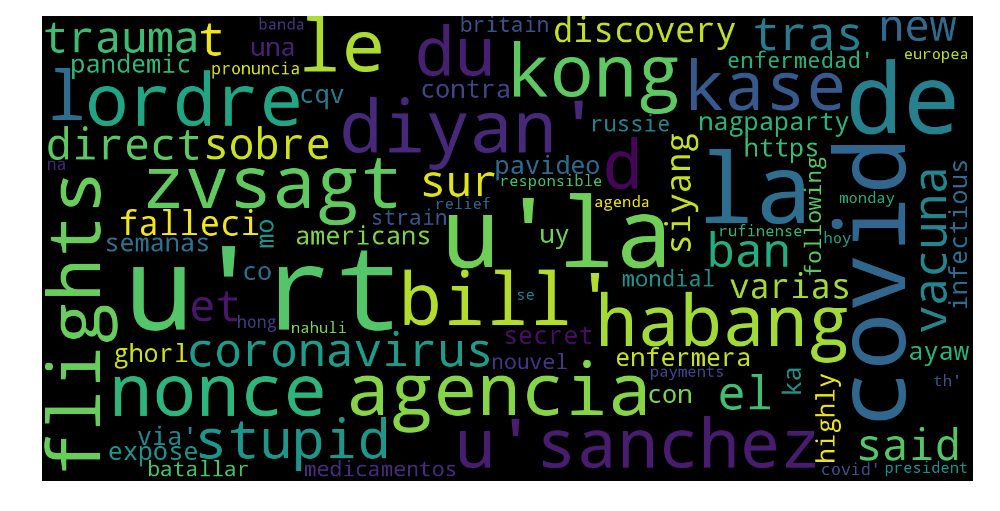

In [28]:
%%local
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(obj)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

W celu dalszej analizy użyty został słownik, który ma predefiniowane uczucia przypisane do słów. (https://github.com/sridharswamy/Twitter-Sentiment-Analysis-Using-Spark-Streaming-And-Kafka/tree/master/Dataset)

In [34]:
%%local
df_tokenized = pd.DataFrame(WordPunctTokenizer().tokenize(obj), columns=['word'])
df_tokenized.head()

In [30]:
%local
%cd /home/sshuser/gettweets
dfDictList = pd.read_csv("sentiments.csv")
dfDictList.head()

/home/sshuser/gettweets


Łączenie danych o sentymentach ze słownikieem dla uzyskania oceny każdego słowa z tweetów

In [38]:
%%local
df_merged = pd.merge(dfDictList, df_tokenized, on='word', how='inner')
df_grouped = df_merged.groupby('sentiment', as_index = False).count()
df_grouped


#### Wniosek numer 2: Z poniższego wykresu słupkowego możemy wywnioskować, że ogólny nastrój z tweetów jest pozytywny

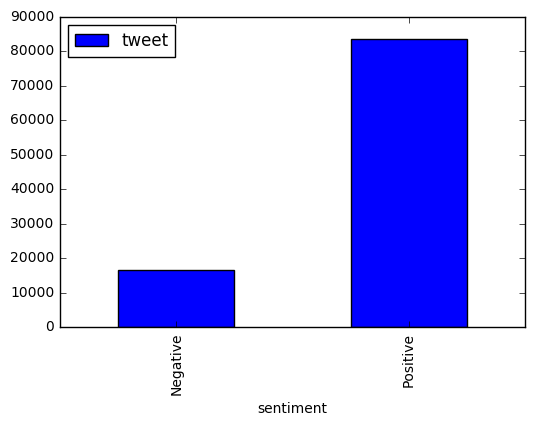

In [37]:
%%local
df_grouped = df_new.groupby('sentiment', as_index = False).count()


labels_word = ['Negative','Positive']
ax = df_grouped.plot(kind = 'bar', x = 'sentiment', y='tweet')
ax.set_xticklabels(labels_word)

### 3. Prosta metoda wykonywania analizy nastrojów.

Używam prostego podejścia do przeprowadzania  analizy i będę używać czystego zestawu danych „tweet_clean”, który stworzyłam w poprzedniej sekcji.
<br>
Importowanie bibliotek Spark API do przyszłej analizy w kontekście Spark SQL.

In [79]:
%%local
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as fn 
import findspark
findspark.init() #aby umożliwić importowanie pyspark jako zwykłej biblioteki.
import warnings
%pwd

u'/home/sshuser/gettweets'

In [80]:
%%local
conf = SparkConf().setMaster("local[4]").setAppName("Sentiment_Project")  # działam w klastrze z 4 wątkami, ale jest on skalowalny również dla środowiska wieloklastrowego.
sc = SparkContext.getOrCreate(conf = conf)
sqlContext = SQLContext(sc)

Tworzenie kontekstu sql do odczytu wyczyszczonych danych w ramce danych spark sql

In [81]:
%%local
%cd /home/sshuser/gettweets
tweet_clean_df = sqlContext.read.csv('/HdiNotebooks/tweets_pandemic_clean.csv', header=True, inferSchema=True)

/home/sshuser/gettweets


In [82]:
%%local
type(tweet_clean_df)

pyspark.sql.dataframe.DataFrame

In [83]:
%%local
tweet_clean_df.dropna().show(5) # dane w czystym formacie i pomyślnie załadowane

+---+--------------------+-------------------+---------+
|_c0|               tweet|                 id|sentiment|
+---+--------------------+-------------------+---------+
|  0|la russie d nonce...|1341007597076422657|        0|
|  1|rt hong kong on m...|1341007597202227203|        1|
|  2|sanchez uy ayaw n...|1341007597483094016|        0|
|  3|the nhs will be o...|1341007597349048320|        1|
|  4|rt monye there is...|1341007598158553091|        0|
+---+--------------------+-------------------+---------+
only showing top 5 rows



In [84]:
%%local
tweet_clean_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- tweet: string (nullable = true)
 |-- id: long (nullable = true)
 |-- sentiment: integer (nullable = true)



Usuwanie pustych wierszy

In [85]:
%%local
tweet_clean_df=tweet_clean_df.dropna()
tweet_clean_df.count()

99195

Przeglądanie pierwszego pozytywnego tweeta

In [86]:
%%local
tweet_clean_df.where(fn.col('sentiment') == 1).first()

Row(_c0=1, tweet=u'rt hong kong on monday said it would ban all flights from britain following the discovery of a new and highly infectious strain of th', id=1341007597202227203, sentiment=1)

Przeglądanie pierwszego negatywnego tweeta

In [87]:
%%local
tweet_clean_df.where(fn.col('sentiment') == 0).first()

Row(_c0=0, tweet=u'la russie d nonce et expose l agenda secret du nouvel ordre mondial sur le covid', id=1341007597076422657, sentiment=0)

Obliczanie średniej długości  pozytywnych i negatywnych tweetów

In [88]:
%%local
pr = tweet_clean_df.select(fn.length('tweet').alias('Positive Tweet Length')).where(fn.col('sentiment') == 1)
pr.select(fn.avg('Positive Tweet Length')).show()

+--------------------------+
|avg(Positive Tweet Length)|
+--------------------------+
|         88.69210497685046|
+--------------------------+



In [89]:
%%local
nr = tweet_clean_df.select(fn.length('tweet').alias('Negative Tweet Length')).where(fn.col('sentiment') == 0)
nr.select(fn.avg('Negative Tweet Length')).show()

+--------------------------+
|avg(Negative Tweet Length)|
+--------------------------+
|        100.48700825643516|
+--------------------------+



#### Wniosek numer 3. Przeanalizowałam, że średni rozmiar tekstu negatywnych tweetów jest większy niż pozytywnych tweetów

Kolumna tweet jest podzielona na słowa za pomocą Tokenizera i połączyłam ją z istniejącym zestawem słów z predefiniowanymi odczuciami, aby obliczyć średni sentyment dla każdego identyfikatora postu.

Odczyt pliku do DataFrame Spark

In [90]:
%%local
df_dict = sqlContext.read.format('csv').options(header = 'true', inferschema='true').load('/HdiNotebooks/sentiments.csv')

In [91]:
%%local
df_dict.printSchema()

root
 |-- word: string (nullable = true)
 |-- sentiment: integer (nullable = true)



In [92]:
%%local
df_dict.show(5) #słowa o znaczeniu negatywnym

+-----------+---------+
|       word|sentiment|
+-----------+---------+
|  abandoned|        0|
|abandonment|        0|
| aberration|        0|
| aberration|        0|
|   abhorred|        0|
+-----------+---------+
only showing top 5 rows



In [93]:
%%local
df_dict.sort(desc("sentiment")).show(5) #słowa o znaczeniu pozytywnym


+---------+---------+
|     word|sentiment|
+---------+---------+
| abidance|        1|
|    above|        1|
| abidance|        1|
|abilities|        1|
|  ability|        1|
+---------+---------+
only showing top 5 rows



In [94]:
%%local
from pyspark.ml.feature import RegexTokenizer

Wybranie takiej samej liczby tweetów pozytywnych i negatywnych ze całego zbioru w celu obliczania doładności klasyfikacji sentymentów

In [112]:
%%local
negative_count = tweet_clean_df.filter("sentiment=0").count()
positive_tweet = tweet_clean_df.filter("sentiment=1")
negative_tweet = tweet_clean_df.filter("sentiment=0")


positive_tweet = positive_tweet.limit(negative_count)
tweet_clean_df = positive_tweet.union(negative_tweet)
tweet_clean_df.count()

32944

Tworzenie obiektu tokenizera do dzielenia kolumny tweet i tworzenia nowej kolumny wyjściowej „splittweet”

In [113]:
%%local
token = RegexTokenizer().setGaps(False).setPattern("\\p{L}+").setInputCol("tweet").setOutputCol("splittweet")

Użycie tokenu do zastosowania zmian

In [114]:
%%local
word_df = token.transform(tweet_clean_df)
word_df.show(5)


+---+--------------------+-------------------+---------+--------------------+
|_c0|               tweet|                 id|sentiment|          splittweet|
+---+--------------------+-------------------+---------+--------------------+
|  1|rt hong kong on m...|1341007597202227203|        1|[rt, hong, kong, ...|
|  3|the nhs will be o...|1341007597349048320|        1|[the, nhs, will, ...|
|  5|    rt chuck collins|1341007597906878464|        1|[rt, chuck, collins]|
|  8|can t wait for th...|1341007598657675266|        1|[can, t, wait, fo...|
|  9|update data sebar...|1341007597952876547|        1|[update, data, se...|
+---+--------------------+-------------------+---------+--------------------+
only showing top 5 rows



Porówuje ze słowami z df_dict, rozbijając podzielone słowa na różne wiersze za pomocą funkcji fn.explode i łącząc DF

In [115]:
%%local
df_dict.show(5)

+-----------+---------+
|       word|sentiment|
+-----------+---------+
|  abandoned|        0|
|abandonment|        0|
| aberration|        0|
| aberration|        0|
|   abhorred|        0|
+-----------+---------+
only showing top 5 rows



In [116]:
%%local
df_joined= word_df.select('id', fn.explode('splittweet').alias('word')).join(df_dict, 'word','leftouter')
df_joined.show(5)

+------+-------------------+---------+
|  word|                 id|sentiment|
+------+-------------------+---------+
|    rt|1341007597202227203|     null|
|  hong|1341007597202227203|     null|
|  kong|1341007597202227203|     null|
|    on|1341007597202227203|     null|
|monday|1341007597202227203|     null|
+------+-------------------+---------+
only showing top 5 rows



In [143]:
%%local
df_joined_wo_null=df_joined.na.fill(0).dropna()
df_joined_wo_null.count()

587383

Wezmę średnią ocenę słów dla każdego tweeta i sklasyfikuje post jako „Pozytywny”, gdy średnia jest większa niż 0 i "Negatywny", jeśli jest mniejsza niż 0, a następnie oblicze wynik dokładności tej metody

In [118]:
%%local
from pyspark.sql import functions as fn 
df_predict = df_joined_wo_null.groupBy('id').agg(fn.avg('sentiment').alias('avg_sentim')).withColumn('pred_sentim', fn.when(fn.col('avg_sentim') > 0, 1).otherwise(0))
df_predict.show(5)

+-------------------+--------------------+-----------+
|                 id|          avg_sentim|pred_sentim|
+-------------------+--------------------+-----------+
|1341007627652837385|                0.04|          1|
|1341007782254964739|                 0.0|          0|
|1341007806447591424|0.041666666666666664|          1|
|1341007847669329920|                 0.0|          0|
|1341007874852593667|                 0.0|          0|
+-------------------+--------------------+-----------+
only showing top 5 rows



Wynik dokładności:

In [120]:
%%local
result=tweet_clean_df.join(df_predict, 'id').select(fn.expr('float(sentiment = pred_sentim)').alias('accuracy_method')).select(fn.avg('accuracy_method'))
result.show(5)

+--------------------+
|avg(accuracy_method)|
+--------------------+
| 0.47459324915007284|
+--------------------+



### 4. Podejście Machine Learning do analizy nastrojów

In [121]:
%%local
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer

#### **--- Usuniecie zbędnych słów (stop words) **

Odczytuje plik tekstowy ze słowami pomijanymi i usuwam je  z kolumny tweet

In [126]:
%%local
%pwd
%ls

sentiments.csv  stopwords.txt  tweets_pandemic_clean.csv


In [127]:
%%local
#Z http://www.lextek.com/manuals/onix/stopwords1.html
with open("stopwords.txt") as f:
    stop_words = f.read().split()

In [128]:
%%local
stop_words[1:10] #odczytanie pierwszych 10 słów

['about',
 'above',
 'across',
 'after',
 'again',
 'against',
 'all',
 'almost',
 'alone']

In [129]:
%%local
#usuniecie słów z tweetów
from pyspark.ml.feature import StopWordsRemover
filter = StopWordsRemover().setStopWords(stop_words).setCaseSensitive(False).setInputCol("splittweet").setOutputCol("words_filter")

#### **Liczenie wektoryzatora**

In [130]:
%%local
from pyspark.ml.feature import CountVectorizer
vector_count = CountVectorizer(minTF=1, minDF=8, vocabSize=2**17).setInputCol("words_filter").setOutputCol("TF")

#### **Pipeline Estymator**

In [131]:
%%local
#Tworze nowy Pipline estymator
C_Pipeline_Est = Pipeline(stages=[token, filter, vector_count]).fit(tweet_clean_df.limit(1000))

In [132]:
%%local
#stosuje transformacji do DF
C_Pipeline_Est.transform(tweet_clean_df).show(5)

+---+--------------------+-------------------+---------+--------------------+--------------------+--------------------+
|_c0|               tweet|                 id|sentiment|          splittweet|        words_filter|                  TF|
+---+--------------------+-------------------+---------+--------------------+--------------------+--------------------+
|  1|rt hong kong on m...|1341007597202227203|        1|[rt, hong, kong, ...|[rt, hong, kong, ...|(131,[0,21,101,10...|
|  3|the nhs will be o...|1341007597349048320|        1|[the, nhs, will, ...|[nhs, offering, c...|(131,[3,12,65],[1...|
|  5|    rt chuck collins|1341007597906878464|        1|[rt, chuck, collins]|[rt, chuck, collins]|     (131,[0],[1.0])|
|  8|can t wait for th...|1341007598657675266|        1|[can, t, wait, fo...|[wait, pandemic, ...|(131,[1,2,7,61],[...|
|  9|update data sebar...|1341007597952876547|        1|[update, data, se...|[update, data, se...|(131,[1,2,3],[1.0...|
+---+--------------------+--------------

#### **IDF (Odwrotna częstotliwość dokumentu- Inverse Document Frequency)**

In [133]:
%%local
from pyspark.ml.feature import IDF
IDF = IDF().setInputCol('TF').setOutputCol('TF_IDF')

In [134]:
%%local
#tworze IDF pipeline
IDF_pip = Pipeline(stages=[C_Pipeline_Est, IDF]).fit(tweet_clean_df)

In [135]:
%%local
#stosuje transformacje
TF_IDF = IDF_pip.transform(tweet_clean_df)
TF_IDF.select('id', 'words_filter', 'TF', "TF_IDF").show(4)

+-------------------+--------------------+--------------------+--------------------+
|                 id|        words_filter|                  TF|              TF_IDF|
+-------------------+--------------------+--------------------+--------------------+
|1341007597202227203|[rt, hong, kong, ...|(131,[0,21,101,10...|(131,[0,21,101,10...|
|1341007597349048320|[nhs, offering, c...|(131,[3,12,65],[1...|(131,[3,12,65],[1...|
|1341007597906878464|[rt, chuck, collins]|     (131,[0],[1.0])|(131,[0],[0.34026...|
|1341007598657675266|[wait, pandemic, ...|(131,[1,2,7,61],[...|(131,[1,2,7,61],[...|
+-------------------+--------------------+--------------------+--------------------+
only showing top 4 rows



 #### ** Dzielenie danych na dane uczące, dane potrzebne do walidacji i dane testowe DF w stosunku 80: 10: 10**

In [136]:
%%local
df_train, df_val, df_test = tweet_clean_df.randomSplit([0.80, 0.10, 0.10], seed=0)

In [137]:
%%local
df_train.count() ,df_val.count() ,df_test.count()

(26371, 3254, 3319)

### 5. Model regresji logistycznej

In [138]:
%%local
#używanie funkcji TF_IDF z IDF pipeline i przekazywanie go do modelu regresji logistycznej
from pyspark.ml.classification import LogisticRegression
LR = LogisticRegression().setLabelCol('sentiment').setFeaturesCol('TF_IDF').setMaxIter(100)

In [139]:
%%local
#tworzenie transformacji pipeline dla regresji logistycznej i uruchamianie na zestawie danych szkoleniowych.
pip_LR = Pipeline(stages=[IDF_pip, LR]).fit(df_train)

In [140]:
%%local
#stoswanie transformacji na DF w celu predykcji sentymentów
pip_LR.transform(df_val).select('id', 'sentiment', 'prediction').show(5)

+-------------------+---------+----------+
|                 id|sentiment|prediction|
+-------------------+---------+----------+
|1341007597202227203|        1|       1.0|
|1341007598657675266|        1|       0.0|
|1341007603304902656|        1|       1.0|
|1341007606895271937|        1|       1.0|
|1341007614214344707|        1|       0.0|
+-------------------+---------+----------+
only showing top 5 rows



In [141]:
%%local
#stosowanie transformacji na danych szkoleniowych(testowych)
pred_test = pip_LR.transform(df_test).select('id', 'sentiment', 'prediction')
pred_test.show(5)

+-------------------+---------+----------+
|                 id|sentiment|prediction|
+-------------------+---------+----------+
|1341007599681024006|        1|       1.0|
|1341007603871133703|        1|       1.0|
|1341007604114440192|        1|       0.0|
|1341007604185767936|        1|       1.0|
|1341007609516744705|        1|       1.0|
+-------------------+---------+----------+
only showing top 5 rows



 #### ** Obliczanie wyniku dokładności na zestawie danych testowych dla naszego modelu ML.**

In [142]:
%%local
acc = pred_test.filter(pred_test.sentiment == pred_test.prediction).count() / float(df_test.count())
acc

0.6962940644772522

** Wniosek numer 4: Dokładność wzrosła o około 20% w porównaniu z podejściem słownikowym, w którym dokładność wynosiła 0.47 **

#### **Ogólne wnioski:**

-- Dokładność przewidywania wzrasta, gdy model uczenia maszynowego w połączeniu z estymatorami Spark i transformatami jest stosowany do zbioru danych sentymentu.
<br>
-- Słowa, które często pojawiają się w danych, mogą powodować błąd podczas przewidywania nastrojów, co można rozwiązać za pomocą wektoryzacji zliczania i metod IDF, które neutralizują wpływ tych słów na wagę.
<br>
-- Wcześniej zauważyłam, że ogólne nastawienie do tweetów było pozytywne, a może to wynikać z oczekiwaniem na szczepionkę. Dlatego uważam, że decyzje podejmowane przez Państwa powinny mieć mieć ukierunkowanie na wsbudzenie nadzieji i lepszego jutra w związku z oczekiwaniem na szczepionkę.
<br>

#### **Problemy związane z analizą sentymentów:**
-- Sentymenty od sarkazmu.
<br>
-- Wiele nastrojów w jednym zdaniu przy użyciu słów takich jak „Mimo to”, które mogą zmienić cały sentyment zdania.

#### **Zalecenia i przyszłe plany: **
-- Techniki takie jak regularyzacja mogą być stosowane wraz z uczeniem maszynowym do optymalizacji.
<br>
-- Spark streaming API czy  Tweepy Streaming mogą służyć do wyodrębniania źródeł danych wczasie rzeczywistym z platform do przeprowadzania analizy opinii.